In [3]:
%matplotlib inline


# Analysis of evoked response using ICA and PCA reduction techniques


This example computes PCA and ICA of evoked or epochs data. Then the
PCA / ICA components, a.k.a. spatial filters, are used to transform
the channel data to new sources / virtual channels. The output is
visualized on the average of all the epochs.



In [4]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets import sample
from mne.decoding import UnsupervisedSpatialFilter

from sklearn.decomposition import PCA, FastICA

# Preprocess data
data_path = sample.data_path()

In [5]:
# Load and filter data, set up epochs
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
event_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
tmin, tmax = -0.1, 0.5 #keep 100 ms before onset to 500ms post-onset
event_id = dict(aud_l=1, aud_r=2, vis_l=3, vis_r=4)

raw = mne.io.read_raw_fif(raw_fname, preload=True)
raw.filter(1, 20, fir_design='firwin') #only select frequencies between 1-20Hz.
events = mne.read_events(event_fname) #captures what events are associated with what categories

picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads') #removes bad trials

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                    picks=picks, baseline=None, preload=True,
                    verbose=False) #generates necessary epoch data for each trial

X = epochs.get_data() # trial_chan_time

Opening raw data file /Users/Hause/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Setting up band-pass filter from 1 - 20 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 5.0 Hz
Filter length of 497 samples (3.310 sec) selected


In [8]:
X.shape #examples,channels,timesteps

(288, 59, 91)

In [29]:
y = epochs.events[:,-1]

Transform data with PCA computed on the average ie evoked response



In [16]:
pca = UnsupervisedSpatialFilter(PCA(30)) #reduce 59 channels down to 30
pca_data = pca.fit_transform(X)
ev = mne.EvokedArray(np.mean(pca_data, axis=0),
                     mne.create_info(30, epochs.info['sfreq'],
                                     ch_types='eeg'), tmin=tmin)


In [17]:
pca_data.shape

(288, 30, 91)

In [18]:
ev.data.shape

(30, 91)

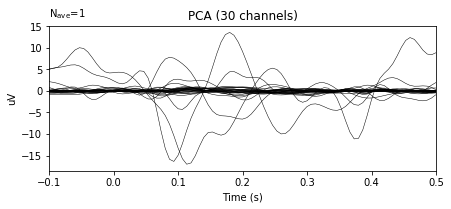

In [19]:
ev.plot(titles="PCA", time_unit='s');

Transform data with ICA computed on the raw epochs (no averaging)



In [21]:
ica = UnsupervisedSpatialFilter(FastICA(30), average=False)
ica_data = ica.fit_transform(X)
ev1 = mne.EvokedArray(np.mean(ica_data, axis=0),
                      mne.create_info(30, epochs.info['sfreq'],
                                      ch_types='eeg'), tmin=tmin)

In [22]:
ev1.data.shape

(30, 91)

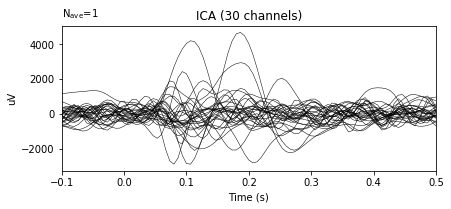

In [23]:
ev1.plot(titles='ICA', time_unit='s');

## Classify among 4 event types over time:

### Compare using all 59 channels for prediction vs. 30 PCA channels vs 30 ICA channels

In [32]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from mne.decoding import SlidingEstimator, cross_val_multiscore, LinearModel, get_coef

In [2]:
clf = make_pipeline(StandardScaler(), LogisticRegression(multi_class="multinomial",solver="lbfgs",max_iter=1000))

time_decod = SlidingEstimator(clf, n_jobs=-1, scoring='accuracy') # train/test timepoint by timepoint

scores_allchannels = cross_val_multiscore(time_decod, X, y, cv=10, n_jobs=-1,verbose=0)
scores_pcachannels = cross_val_multiscore(time_decod, pca_data, y, cv=10, n_jobs=-1,verbose=0)
scores_icachannels = cross_val_multiscore(time_decod, ica_data, y, cv=10, n_jobs=-1,verbose=0)

NameError: name 'X' is not defined

In [28]:
# Mean scores across cross-validation splits per channel selection technique
scores_allchannels = np.mean(scores_allchannels, axis=0)
scores_pcachannels = np.mean(scores_pcachannels, axis=0)
scores_icachannels = np.mean(scores_icachannels, axis=0)

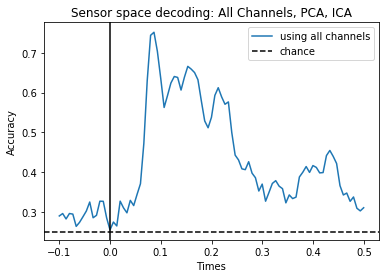

In [66]:
# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores_allchannels, label='using all channels')
# ax.plot(epochs.times, scores_pcachannels, label='using pca channels')
# ax.plot(epochs.times, scores_icachannels, label='using ica channels')
ax.axhline(.25, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('Accuracy')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding: All Channels, PCA, ICA')
plt.show()

In [31]:
# You can retrieve the spatial filters and spatial patterns if you explicitly
# wrap the LR in a LinearModel object
clf = make_pipeline(StandardScaler(), LinearModel(LogisticRegression(multi_class="multinomial",
                                                                     solver="lbfgs",
                                                                     max_iter=1000)))
time_decod = SlidingEstimator(clf, n_jobs=-1, scoring='accuracy')
time_decod.fit(X, y)

coef = get_coef(time_decod, 'patterns_', inverse_transform=True)

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    3.5s remaining:    3.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.7s finished


In [80]:
joint_kwargs = dict(ts_args=dict(time_unit='s'),
                    topomap_args=dict(time_unit='s'))

evoked_coef0 = mne.EvokedArray(coef[:,0,:], epochs.info, tmin=epochs.times[0])
evoked_coef0.plot_joint(times=np.arange(-.100, .500, .100), title='patterns_coef0',
                   **joint_kwargs);

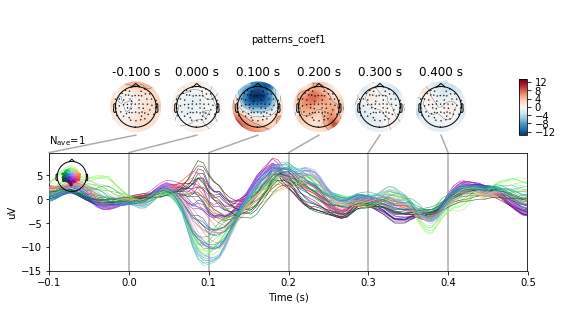

In [93]:
evoked_coef1 = mne.EvokedArray(coef[:,1,:], epochs.info, tmin=epochs.times[0])
evoked_coef1.plot_joint(times=np.arange(-.100, .500, .100), title='patterns_coef1',
                  **joint_kwargs);

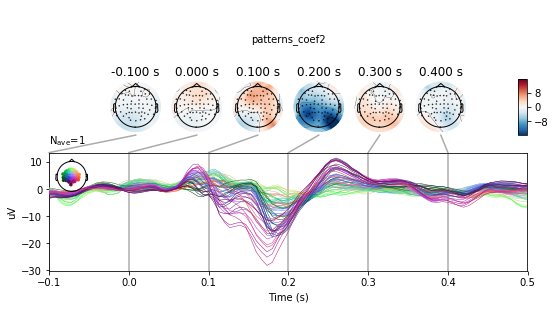

In [91]:
evoked_coef2 = mne.EvokedArray(coef[:,2,:], epochs.info, tmin=epochs.times[0])
evoked_coef2.plot_joint(times=np.arange(-.100, .500, .100), title='patterns_coef2',
                  **joint_kwargs);

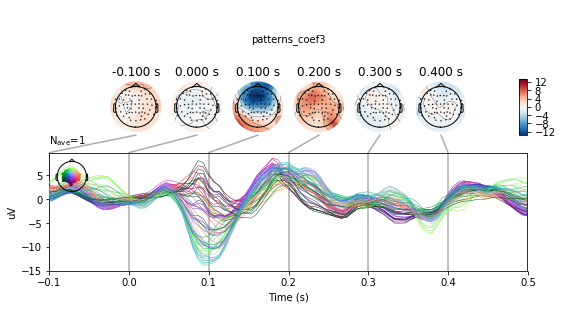

In [94]:
evoked_coef3 = mne.EvokedArray(coef[:,3,:], epochs.info, tmin=epochs.times[0])
evoked_coef1.plot_joint(times=np.arange(-.100, .500, .100), title='patterns_coef3',
                  **joint_kwargs);